In [12]:
#COLAB = True

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
#import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/DatasetFinal')

In [15]:
#import os
#os.listdir()

In [16]:
# ===============================================================
# NOTEBOOK: Predicción precio luz (10–20 Septiembre 2025)
# Basado en pipeline hasta el punto 3.2 del notebook original
# ===============================================================

# 1. CONFIGURACIÓN Y DEPENDENCIAS
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use("seaborn-v0_8-whitegrid")

# Rutas
MODEL_PATH = "precio_luz_xgb.pkl"
DATA_PRECIOS_PATH = "datasets/df_precios_2024_2025.parquet"
DATA_REE_PATH = "datasets/df_ree.parquet"


In [17]:
#print(os.listdir())

In [18]:
# 2. CARGA DE DATOS Y MODELO
xgb_model = joblib.load(MODEL_PATH)
df_precios = pd.read_parquet(DATA_PRECIOS_PATH).reset_index()
df_ree = pd.read_parquet(DATA_REE_PATH).reset_index()

print("✅ Datos cargados correctamente")
print("Precios:", df_precios.shape)
print("REE:", df_ree.shape)
print("Columnas precios:", df_precios.columns[:5].tolist())
print("Columnas REE:", df_ree.columns[:5].tolist())

✅ Datos cargados correctamente
Precios: (15118, 17)
REE: (15048, 66)
Columnas precios: ['ts_utc', 'Dia', 'Hora', 'hour', 'price']
Columnas REE: ['ts_utc', 'dem_real', 'dem_prevista', 'dem_programada', 'gen_eolica']


In [19]:
df_precios.head(1)

,ts_utc,Dia,Hora,hour,price,PCB,COF2TD,PMHPCB,SAHPCB,FOMPCB,FOSPCB,INTPCB,PCAPPCB,TEUPCB,CCVPCB,EDSRPCB,TAHPCB
0,2023-12-31 23:00:00+00:00,01/01/2024,00-01,00,123.83,123.83,0.00012,77.57,26.31,0.05,0.22,0.0,0.0,2.75,3.21,0.0,13.73


In [20]:
print("Columnas df_precios:", df_precios.columns.tolist()[:10])
print("Columnas df_ree:", df_ree.columns.tolist()[:10])

Columnas df_precios: ['ts_utc', 'Dia', 'Hora', 'hour', 'price', 'PCB', 'COF2TD', 'PMHPCB', 'SAHPCB', 'FOMPCB']
Columnas df_ree: ['ts_utc', 'dem_real', 'dem_prevista', 'dem_programada', 'gen_eolica', 'gen_nuclear', 'gen_carbon', 'gen_ciclo_combinado', 'gen_intercambios_int', 'gen_solar_fotovoltaica']


In [21]:
print("Precios:", df_precios["ts_utc"].min(), "→", df_precios["ts_utc"].max())
print("REE:", df_ree["ts_utc"].min(), "→", df_ree["ts_utc"].max())

Precios: 2023-12-31 23:00:00+00:00 → 2025-09-21 21:00:00+00:00
REE: 2024-01-01 00:00:00+00:00 → 2025-09-20 23:00:00+00:00


In [22]:
print(df_precios["ts_utc"].dtype)
print(df_ree["ts_utc"].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]


In [23]:
# ====================================================
# 🧩 1. Arreglar y asegurar la columna de tiempo
# ====================================================
df_precios["ts_utc"] = pd.to_datetime(df_precios["ts_utc"]).dt.tz_localize(None)
df_ree["ts_utc"] = pd.to_datetime(df_ree["ts_utc"]).dt.tz_localize(None)

# Eliminar duplicados y nulos
df_precios = df_precios.dropna(subset=["ts_utc"]).drop_duplicates(subset="ts_utc")
df_ree = df_ree.dropna(subset=["ts_utc"]).drop_duplicates(subset="ts_utc")

print("Precios:", df_precios["ts_utc"].min(), "→", df_precios["ts_utc"].max())
print("REE:", df_ree["ts_utc"].min(), "→", df_ree["ts_utc"].max())

# ====================================================
# 🧩 2. Ordenar antes del merge_asof
# ====================================================
df_precios = df_precios.sort_values("ts_utc").reset_index(drop=True)
df_ree = df_ree.sort_values("ts_utc").reset_index(drop=True)


# 3️⃣ Validar rangos de fechas antes del merge
print("📅 Rangos temporales antes del merge:")
print(f"Precios: {df_precios['ts_utc'].min()} → {df_precios['ts_utc'].max()}")
print(f"REE:     {df_ree['ts_utc'].min()} → {df_ree['ts_utc'].max()}")

# 4️⃣ Comprobar diferencias típicas de frecuencia
print("\n🔎 Frecuencias promedio:")
print(df_precios["ts_utc"].diff().value_counts().head())
print(df_ree["ts_utc"].diff().value_counts().head())

# 5️⃣ Merge temporal tolerante (1 hora)
df = pd.merge_asof(
    df_precios,
    df_ree,
    on="ts_utc",
    direction="nearest",
    tolerance=pd.Timedelta("1h")  # ← Tolerancia de 1 hora exacta
)

# 6️⃣ Validar resultado
print("\n✅ Merge completado correctamente")
print(f"Filas después del merge: {len(df)}")
print("Rango temporal final:", df["ts_utc"].min(), "→", df["ts_utc"].max())

# 7️⃣ Comprobar si quedaron valores nulos críticos
print("\n🔍 Porcentaje de NaN en columnas clave:")
print(df[["price", "dem_real", "gen_ciclo_combinado"]].isna().mean())


Precios: 2023-12-31 23:00:00 → 2025-09-21 21:00:00
REE: 2024-01-01 00:00:00 → 2025-09-20 23:00:00
📅 Rangos temporales antes del merge:
Precios: 2023-12-31 23:00:00 → 2025-09-21 21:00:00
REE:     2024-01-01 00:00:00 → 2025-09-20 23:00:00

🔎 Frecuencias promedio:
ts_utc
0 days 01:00:00    15116
0 days 02:00:00        1
Name: count, dtype: int64
ts_utc
0 days 01:00:00    15045
1 days 01:00:00        2
Name: count, dtype: int64

✅ Merge completado correctamente
Filas después del merge: 15118
Rango temporal final: 2023-12-31 23:00:00 → 2025-09-21 21:00:00

🔍 Porcentaje de NaN en columnas clave:
price                  0.000000
dem_real               0.004498
gen_ciclo_combinado    0.004498
dtype: float64


In [24]:
import numpy as np
import pandas as pd

# ============================================================
# 3.3 FEATURES TEMPORALES AVANZADAS
# ============================================================
df["dow"] = df["ts_utc"].dt.dayofweek
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)

df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 7)

# ============================================================
# 3.4 SERIES TEMPORALES Y LAGS
# ============================================================
def add_lag(df, col, lags):
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

def add_rolling(df, col, windows):
    for w in windows:
        df[f"{col}_roll{w}_mean"] = df[col].rolling(w).mean()
        df[f"{col}_roll{w}_std"] = df[col].rolling(w).std()
    return df

df = add_lag(df, "price", [1, 2, 3, 24, 48, 168])
df = add_rolling(df, "price", [3, 6, 24])

for col in ["dem_real", "gen_ciclo_combinado", "emis_ciclo_combinado",
            "gen_solar_fotovoltaica", "alm_entrega_de_baterias",
            "PMHPCB", "CCVPCB"]:
    if col in df.columns:
        df = add_lag(df, col, [1, 24, 168])

# ============================================================
# 3.5 SERIES DE FOURIER (estacionalidad)
# ============================================================
df["week"] = df["ts_utc"].dt.isocalendar().week.astype(int)
for k in range(1, 4):
    df[f"fourier_w_sin{k}"] = np.sin(2 * np.pi * k * df["week"] / 52)
    df[f"fourier_w_cos{k}"] = np.cos(2 * np.pi * k * df["week"] / 52)

# ============================================================
# 3.6 INDICADORES DE VALORES FALTANTES
# ============================================================
for col in df.columns:
    if "lag" in col or "roll" in col:
        df[f"{col}_isna"] = df[col].isna().astype(int)

# ============================================================
# 3.7 LIMPIEZA FINAL
# ============================================================
filas_antes = len(df)
df = df.dropna(subset=["price"]).reset_index(drop=True)
print(f"✅ Features extendidas creadas correctamente ({len(df)} / {filas_antes} filas)")
print("Rango temporal:", df['ts_utc'].min(), "→", df['ts_utc'].max())


✅ Features extendidas creadas correctamente (15118 / 15118 filas)
Rango temporal: 2023-12-31 23:00:00 → 2025-09-21 21:00:00


In [25]:
import json, tempfile, xgboost as xgb

# Guardar el contenido JSON del booster temporalmente
with tempfile.NamedTemporaryFile(suffix=".json", delete=False) as tmp:
    tmp.write(xgb_model["booster_json"].encode("utf-8"))
    tmp_path = tmp.name

# Cargar correctamente el modelo desde ese archivo
booster = xgb.Booster()
booster.load_model(tmp_path)

# Recuperar las features
features = booster.feature_names
print(f"✅ Modelo XGBoost reconstruido correctamente con {len(features)} features.")


✅ Modelo XGBoost reconstruido correctamente con 69 features.


In [65]:
# --- 🔹 Crear df_valid solo para el periodo de validación ---
start_date = "2025-09-15 00:00:00"
end_date   = "2025-09-21 23:00:00"

# Filtramos el dataframe original (asegúrate de que df tenga 'ts_utc')
df_valid = df[(df["ts_utc"] >= start_date) & (df["ts_utc"] <= end_date)].copy()

print(f"✅ df_valid creado para validación:")
print(f"   Rango temporal: {df_valid['ts_utc'].min()} → {df_valid['ts_utc'].max()}")
print(f"   Total de filas: {len(df_valid)}")

# --- 🔹 Asegurar que las columnas temporales clave existan ---
df_valid["hour"] = df_valid["ts_utc"].dt.hour
df_valid["dow"] = df_valid["ts_utc"].dt.dayofweek
df_valid["is_weekend"] = (df_valid["dow"] >= 5).astype(int)

# --- 🔹 Generar features trigonométricas y Fourier ---
df_valid["hour_sin"] = np.sin(2 * np.pi * df_valid["hour"] / 24)
df_valid["hour_cos"] = np.cos(2 * np.pi * df_valid["hour"] / 24)
df_valid["dow_sin"] = np.sin(2 * np.pi * df_valid["dow"] / 7)
df_valid["dow_cos"] = np.cos(2 * np.pi * df_valid["dow"] / 7)

df_valid["week"] = df_valid["ts_utc"].dt.isocalendar().week.astype(int)
for k in range(1, 4):
    df_valid[f"fourier_w_sin{k}"] = np.sin(2 * np.pi * k * df_valid["week"] / 52)
    df_valid[f"fourier_w_cos{k}"] = np.cos(2 * np.pi * k * df_valid["week"] / 52)

print("✅ Features temporales y Fourier generadas correctamente.")


✅ df_valid creado para validación:
   Rango temporal: 2025-09-15 00:00:00 → 2025-09-21 21:00:00
   Total de filas: 166
✅ Features temporales y Fourier generadas correctamente.


In [67]:
# Asegurar que todas las features estén presentes
missing_features = [f for f in features if f not in df_valid.columns]

print(f"⚠️ Faltan {len(missing_features)} columnas que el modelo espera.")
if missing_features:
    print("→ Se crearán temporalmente con valor 0.")
    for col in missing_features:
        df_valid[col] = 0.0 if not col.endswith("_isna") else 0

# Predicción
X = df_valid[features].replace([np.inf, -np.inf], np.nan).fillna(0)
dmatrix = xgb.DMatrix(X)
df_valid["predicted_price"] = booster.predict(dmatrix)

⚠️ Faltan 16 columnas que el modelo espera.
→ Se crearán temporalmente con valor 0.


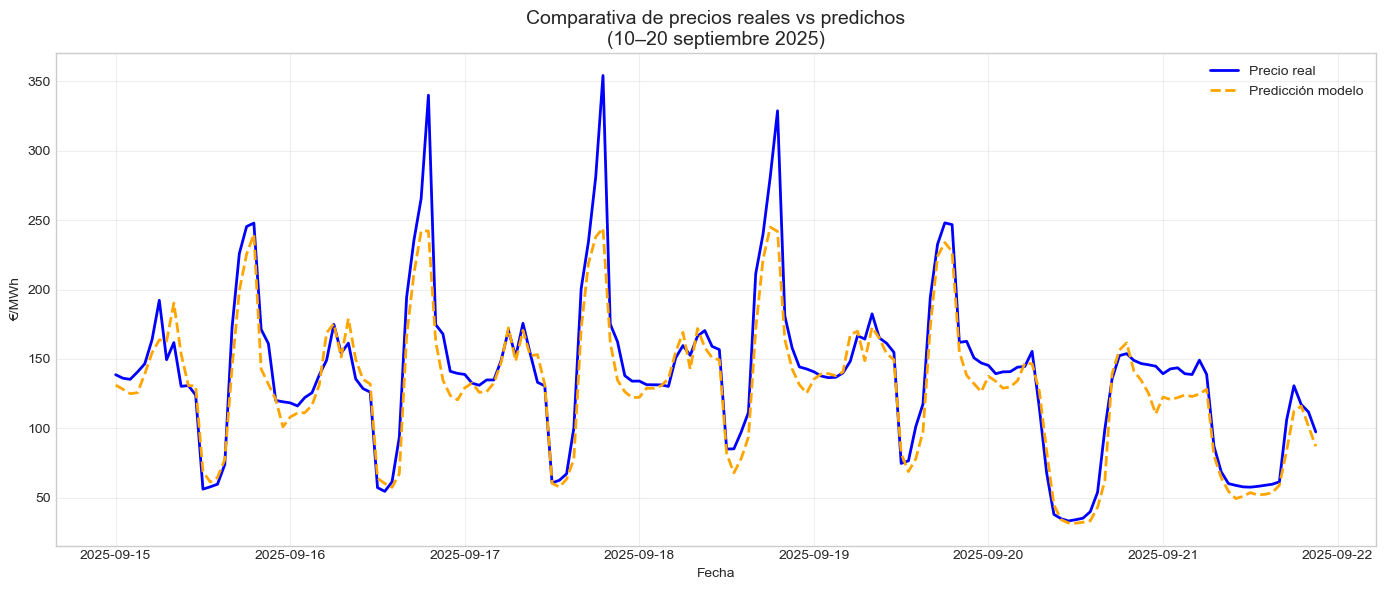

In [69]:
plt.figure(figsize=(14, 6))
plt.plot(df_valid["ts_utc"], df_valid["price"], label="Precio real", color="blue", linewidth=2)
plt.plot(df_valid["ts_utc"], df_valid["predicted_price"], label="Predicción modelo", color="orange", linestyle="--", linewidth=2)
plt.title("Comparativa de precios reales vs predichos\n(10–20 septiembre 2025)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("€/MWh")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()